- [Tutorial of Streaming](https://www.youtube.com/watch?v=TCqr9HNcrsI&list=PL3MmuxUbc_hIUISrluw_A7wDSmfOhErJK&index=31)

## Machine Learning for Streaming

- Scenario
- Creating a role
- Create a `Lambda function`, test it
- Create a `Kinesis stream`
- Connect the function to the stream
- Send records

- [Tutorial: Using Amazon Lambda with Amazon Kinesis](https://docs.amazonaws.cn/en_us/lambda/latest/dg/with-kinesis-example.html)
- [Using lambda function for DL example](https://github.com/alexeygrigorev/mlbookcamp-code/tree/master/chapter-08-serverless)

### What is AWS [Lambda function](https://docs.aws.amazon.com/lambda/latest/dg/welcome.html)?

- Lambda is a compute service that lets you run code without provisioning or managing servers;
- Lambda runs your code on a high-availability compute infrastructure and performs all of the administration of the compute resources;
- You organize  your code into Lambda functions:
    - Lambda runs your code when needed and scales automatically, from a few requests per day to thousands per second
- **You pay only for the compute time that you consume** - **there is no charge when your code is not running**
- You can invoce your Lambda functions using **Lambda API** or **Lambda** can run your functions in response to events from other **AWS services**.
    
    Examples:
    - Build data-processing triggers for AWS services such as Amazon Simple Storage Service (Amazon S3) and Amazon DynamoDB;
    - Create your own backend that operates at AWS scale;
    - **Process streaming data stored in Amazon Kinesis**;
    
**When to use it and alternatives**
- Lambda is responsible only for your code. Lambda manages the compute fleet that offers a balance of memory, CPU, network, and other resources to run your code. You cannot log in to compute instances or customize the OS on provided runtimes. 
- If you need to manage your own compute resources, you should use other services, such as:
    - Amazon EC2 - offers a wide variety of EC2 instances, it lets you customize OS, network, and security. And you are responsible for provisioning capacity, monitoring fleet health and performance, and using Availability Zones for fault tolerance;
    - AWS Elastic Beanstalk enables you to deploy and scale applications onto Amazon EC2. You retain ownership and full control over the underlying EC2 instances;

### What is AWS [Kinesis](https://aws.amazon.com/kinesis/?nc1=h_ls)?

Amazon Kinesis is an AWS service designed to process large-scale data streams from multitude of services in real-time. It can be considered, like `Apache Kafka`, as a kind of message broker. This means that it operates as a middleman between various data generating sources, to allow other applications or services to work with the source data.

One of the key benefits, is that it allows you to process and analyze data nearly immediately, rather than waiting for a complete dataset to arrive, then processing it, then delivering it for analysis. Kinesis makes this possible without weeks of complicated setup, as it is delivered as a managed platform, meaning you do not have to manage any infrastructure.

In short, **Kinesis** is designed to ingest, process, and analyze streams of data in real-time. Within this core skillset, it offers **four key solutions**:
1. **Amazon Kinesis Data Stream**
2. Amazon Kinesis Video Stream
3. Amazon Kinesis Firehose
4. Amazon Kinesis Data Analytics (can be used for personal use)

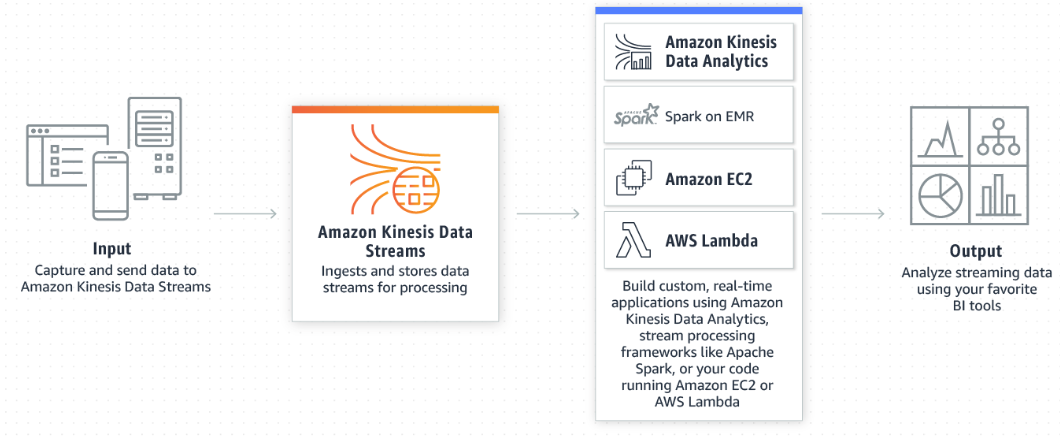

**Use Cases: Build real-time applications**


You can use Amazon Kinesis for real-time applications such as application monitoring, fraud detection, and live leader-boards. You can ingest streaming data using Kinesis Data Streams, process it using Kinesis Data Analytics, and emit the results to any data store or application using Kinesis Data Streams with millisecond end-to-end latency. This can help you learn about what your customers, applications, and products are doing right now and react promptly.

**Netflix:** uses it to monitor the communications between all of its applications so it can detect and fix issues quickly, ensuring high service uptime and availability to its customers.

## Streaming: Deploying models with Kinesis and Lambda

### 1.1 Set Up AWS on your local computer

- `sudo apt-get update`
- `sudo apt-get install awscli`
- `aws --version`

[Tutorial: How to install aws in ubuntu](https://www.fosstechnix.com/how-to-install-aws-cli-on-ubuntu/)

In [1]:
! aws --version

aws-cli/1.22.34 Python/3.10.4 Linux/5.15.0-25-generic botocore/1.23.34


### 1.3 Create a Execution Role

This will allow us to connect `Kinesis` with `Lambda function`. Which will describe what kind of permissions `lambda function` will have and particularly we will set a connection with `Kinesis`

- Go to `IAM` dashboard > `Create a Role`;
- Use case: `Lambda`;
- Permission policies: `AWSLambdaKinesisExecutionRole` - and select the only one that appears there;
- Role name: `lambda-kinesis-role`
- Press `create role`

### 1.2 Create a lambda function

- Go to `lambda` service > `Create a function`

#### 1.2.2. Lambda test function

- Function name: `ride-duration-prediction-test`
- Runtime: `Python3.9`
- Change the default execution role to: `Use existing` > Select the one created
- Press `create function`

Notes:
- Everytime a lambda function is changed -> press `Deploy`;
- Create an event to test the function (in `Test` button);
- The **Id** of an event is necessary in `streaming` so we are able to find to correlated with the prediction;

### 1.3 Connect Lambda function to Kinesis

It is important to first simplify the output, so one can understand how Kinesis is giving the information to Lambda. This process may be a bit iterative.

#### 1.3.1 Create a Kinesis Data Stream

- **Create Kinesis Stream and Lambda function in the same location**:

- Data Stream name: `ride-events`
- Capacity mode: `Provisioned`
- Provisioned shards: `1` - Select based on how many events do we have
- Hit `create data stream`


**Important:** We need to pay for each shard per hour -> so we should stop them after the tutorial - [pricing](https://aws.amazon.com/kinesis/data-streams/pricing/)
- **Delete it** after finishing the experiment


#### 1.3.2 Connect to Lambda

- Go to our lambda function
- Add trigger > select `Kinesis`

Trigger Configuration:
- Name: `ride-events`
- And hit `Add`

### 1.4 Test Lambda <> Kinesis

#### 1.4.1 Send an event to the stream

Before that one should configure the test as:
```bash
{
  "ride": {
    "PULocationID": 130,
    "DOLocationID": 205,
    "trip_distance": 3.66
  },
  "ride_id": 123
}
```

And the lambda function as:
```python 
import json

def prepare_features(ride):
    features = {}
    features['PU_DO'] = '%s_%s' % (ride['PULocationID'], ride['DOLocationID'])
    features['trip_distance'] = ride['trip_distance']
    return features


def predict(features):
    return 10.0


def lambda_handler(event, context):
    
    #ride = event['ride']
    #ride_id = event['ride_id']
    
    #features = prepare_features(ride)
    #prediction = predict(features)

    print(json.dumps(event))
    prediction = 10
    ride_id = '123'
    return {
        'ride_duration':prediction, 
        'ride_id':ride_id,
    }
```

The goal is to understand how `lambda` is reciving `Kinesis` data to encode it

```bash
KINESIS_STREAM_INPUT=ride-events
aws kinesis put-record \
    --stream-name ${KINESIS_STREAM_INPUT} \
    --partition-key 1 \
    --data "Hello, this is a test."
    
```

Response:

- Returns a dictionary with two informations: `shardID` and `SequenceNumber`

#### 1.4.2 Go to `lambda function` logs to check how did it reacted

- Go to `lambda function` = `ride-duration-prediction-test` > `Monitor`;
- View `logs in CloudWatch` to check how **lambda is reciving information**:

- This is basically an encoding way of how lambda will receive the information of the kinesis function

```bash
{
    "Records": [
        {
            "kinesis": {
                "kinesisSchemaVersion": "1.0",
                "partitionKey": "1",
                "sequenceNumber": "49632656867294236735995561488277353304929414720251756546",
                "data": "SGVsbG8sIHRoaXMgaXMgYSB0ZXN0Lg==",
                "approximateArrivalTimestamp": 1661382934.881
            },
            "eventSource": "aws:kinesis",
            "eventVersion": "1.0",
            "eventID": "shardId-000000000000:49632656867294236735995561488277353304929414720251756546",
            "eventName": "aws:kinesis:record",
            "invokeIdentityArn": "arn:aws:iam::170107914870:role/lambda-kinesis-role",
            "awsRegion": "eu-west-1",
            "eventSourceARN": "arn:aws:kinesis:eu-west-1:170107914870:stream/ride-events"
        }
    ]
}
```

- Our event is with in "Records" - "kinesis" - "data"

```bash
"data": "SGVsbG8sIHRoaXMgaXMgYSB0ZXN0Lg==",
```

- And what we actually send was:

```bash
--data "Hello, this is a test."

```


- **So we need to decode it - base64 encoding**

In [1]:
import base64

In [2]:
data_encoded = "SGVsbG8sIHRoaXMgaXMgYSB0ZXN0Lg=="
base64.b64decode(data_encoded).decode('utf-8')

'Hello, this is a test.'

- Do not forget that it comes a bunch of data, so we will need to perform a for loop to read it:

In [5]:
event = {
    "Records": [
        {
            "kinesis": {
                "kinesisSchemaVersion": "1.0",
                "partitionKey": "1",
                "sequenceNumber": "49631783078782244062766649844394684993861955912751644674",
                "data": "SGVsbG8sIHRoaXMgaXMgYSB0ZXN0Lg==",
                "approximateArrivalTimestamp": 1658929938
            },
            "eventSource": "aws:kinesis",
            "eventVersion": "1.0",
            "eventID": "shardId-000000000000:49631783078782244062766649844394684993861955912751644674",
            "eventName": "aws:kinesis:record",
            "invokeIdentityArn": "arn:aws:iam::170107914870:role/lambda-kinesis-role",
            "awsRegion": "us-east-1",
            "eventSourceARN": "arn:aws:kinesis:us-east-1:170107914870:stream/ride-events"
        }
    ]
}

In [7]:
for record in event['Records']:
    encoded_data = record['kinesis']['data']
    decoded_data = base64.b64decode(encoded_data).decode('utf-8')
    print(decoded_data)

Hello, this is a test.


#### 1.4.2 Send a the real event to Kinesis

```bash
KINESIS_STREAM_INPUT=ride-events
aws kinesis put-record \
    --stream-name ${KINESIS_STREAM_INPUT} \
    --partition-key 1 \
    --data '{
        "ride": {
            "PULocationID": 130,
            "DOLocationID": 205,
            "trip_distance": 3.66
        }, 
        "ride_id": 156
    }'
```

Response:

```bash
{
    "ShardId": "shardId-000000000000",
    "SequenceNumber": "49631783078782244062766649846789567042518784522594549762"
}
```

- The event received in **lambda function**: (Monitor)

```bash
{
    "Records": [
        {
            "kinesis": {
                "kinesisSchemaVersion": "1.0",
                "partitionKey": "1",
                "sequenceNumber": "49632656867294236735995561488278562230749104803411918850",
                "data": "ewogICAgICAgICJyaWRlIjogewogICAgICAgICAgICAiUFVMb2NhdGlvbklEIjogMTMwLAogICAgICAgICAgICAiRE9Mb2NhdGlvbklEIjogMjA1LAogICAgICAgICAgICAidHJpcF9kaXN0YW5jZSI6IDMuNjYKICAgICAgICB9LCAKICAgICAgICAicmlkZV9pZCI6IDE1NgogICAgfQ==",
                "approximateArrivalTimestamp": 1661384032.549
            },
            "eventSource": "aws:kinesis",
            "eventVersion": "1.0",
            "eventID": "shardId-000000000000:49632656867294236735995561488278562230749104803411918850",
            "eventName": "aws:kinesis:record",
            "invokeIdentityArn": "arn:aws:iam::170107914870:role/lambda-kinesis-role",
            "awsRegion": "eu-west-1",
            "eventSourceARN": "arn:aws:kinesis:eu-west-1:170107914870:stream/ride-events"
        }
    ]
}
```

- **So we need to decode it - base64 encoding**

In [3]:
import json

In [11]:
event = {
    "Records": [
        {
            "kinesis": {
                "kinesisSchemaVersion": "1.0",
                "partitionKey": "1",
                "sequenceNumber": "49632656867294236735995561488278562230749104803411918850",
                "data": "ewogICAgICAgICJyaWRlIjogewogICAgICAgICAgICAiUFVMb2NhdGlvbklEIjogMTMwLAogICAgICAgICAgICAiRE9Mb2NhdGlvbklEIjogMjA1LAogICAgICAgICAgICAidHJpcF9kaXN0YW5jZSI6IDMuNjYKICAgICAgICB9LCAKICAgICAgICAicmlkZV9pZCI6IDE1NgogICAgfQ==",
                "approximateArrivalTimestamp": 1661384032.549
            },
            "eventSource": "aws:kinesis",
            "eventVersion": "1.0",
            "eventID": "shardId-000000000000:49632656867294236735995561488278562230749104803411918850",
            "eventName": "aws:kinesis:record",
            "invokeIdentityArn": "arn:aws:iam::170107914870:role/lambda-kinesis-role",
            "awsRegion": "eu-west-1",
            "eventSourceARN": "arn:aws:kinesis:eu-west-1:170107914870:stream/ride-events"
        }
    ]
}

In [13]:
for record in event['Records']:
    encoded_data = record['kinesis']['data']
    decoded_data = base64.b64decode(encoded_data).decode('utf-8')
    ride_event = json.loads(decoded_data) # returns a json file
    print(ride_event)

{'ride': {'PULocationID': 130, 'DOLocationID': 205, 'trip_distance': 3.66}, 'ride_id': 156}


### 1.5 Lambda function: before sending predictions to client

```python
import json
import base64



def prepare_features(ride):
    features = {}
    features['PU_DO'] = '%s_%s' % (ride['PULocationID'], ride['DOLocationID'])
    features['trip_distance'] = ride['trip_distance']
    return features

def predict(features):
    return 10.0

def lambda_handler(event, context):

    print(json.dumps(event))
    
    # We have multiple predictions - because lambda might consume 100 events
    predictions = []
    for record in event['Records']:
        encoded_data = record['kinesis']['data']
        decoded_data = base64.b64decode(encoded_data).decode('utf-8')
        ride_event = json.loads(decoded_data) # returns a json file
        print(ride_event)
    
    
        ride = ride_event['ride']
        ride_id = ride_event['ride_id']
        features = prepare_features(ride)
        prediction = predict(features)
        
        # We will send this to a different stream - to show to the client
        prediction_event = {
            'model': 'ride_duration_prediction_model',
            'version': '123'
            'prediction': {
                'ride_duration': prediction,
                'ride_id': ride_id
            },
        }
        
        predictions.append(prediction_event)
        

    return {
        'predictions': predictions,
    }
```

### 1.6 Create the second data stream to receive the predictions

- Data Stream name: `ride-predictions`
- Capacity mode: `Provisioned`
- Provisioned shards: `1` - Select based on how many events do we have
- Hit `create data stream`

**To send data to another Kinesis Data Stream:**
- We need boto3 - that has a `client()` method which is responsible to connect to a Kinesis stream - [more info](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/kinesis.html)
- We will need the `put_records()` function, for that we have the following example:

```python
response = client.put_record(
    StreamName='string',
    Data=b'bytes',
    PartitionKey='string',
    ExplicitHashKey='string',
    SequenceNumberForOrdering='string'
)
```

- That we should adapt to our specific example:

```python
response = kinesis_client.put_record(
    StreamName=PREDICTIONS_STREAM_NAME,
    Data=json.dumps(prediction_event),
    PartitionKey=str(ride_id),
)
```

**Note:** Since we pay for every API call, we should consider using `put_records()` instead of `put_record` method, when we have a bunch of data.

**Lambda function connected with output Kinesis Data Stream**:

```python
import os
import json
import base64
import boto3

# To interact with Kinesis Stream
kinesis_client = boto3.client('kinesis')
PREDICTIONS_STREAM_NAME = os.getenv('PREDICTIONS_STREAM_NAME', 'ride-predictions')

def prepare_features(ride):
    features = {}
    features['PU_DO'] = '%s_%s' % (ride['PULocationID'], ride['DOLocationID'])
    features['trip_distance'] = ride['trip_distance']
    return features

def predict(features):
    return 10.0

def lambda_handler(event, context):

    print(json.dumps(event))

    # We have multiple predictions - because lambda might consume 100 events
    predictions_events = []
    for record in event['Records']:
        encoded_data = record['kinesis']['data']
        decoded_data = base64.b64decode(encoded_data).decode('utf-8')
        ride_event = json.loads(decoded_data) # returns a json file
        print(ride_event)


        ride = ride_event['ride']
        ride_id = ride_event['ride_id']
        
        features = prepare_features(ride)
        prediction = predict(features)

        # We will send this to a different stream - to show to the client
        prediction_event = {
            'model': 'ride_duration_prediction_model',
            'version': '123',
            'prediction': {
                'ride_duration': prediction,
                'ride_id': ride_id
            },
        }

        # After each prediction event we will send data to Kinesis Data Stream
        response = kinesis_client.put_record(
            StreamName=PREDICTIONS_STREAM_NAME,
            Data=json.dumps(prediction_event),
            PartitionKey=str(ride_id),
        )

        predictions_events.append(prediction_event)


    return {
        'predictions': prediction_event,
    }
```

**We need to add permissions to write into the role we created** otherwise it will not work. The permission name, should appear in the error:

```bash 
"errorMessage": "An error occurred (AccessDeniedException) when calling the PutRecord operation: User: arn:aws:sts::170107914870:assumed-role/lambda-kinesis-role/ride-duration-prediction-test is not authorized to perform: kinesis:PutRecord on resource: arn:aws:kinesis:us-east-1:170107914870:stream/ride_predictions because no identity-based policy allows the kinesis:PutRecord action",
```

- Go to `IAM` and `lambda-kinesis-role` to attach `kinesis:PutRecord` policy:
1. Attach policy
2. Create policy

Configurations:
- Service: kinesis
- Actions: Write > PutRecord and PutRecords
- Resources: `Available in the error message, it starts with an arn`
- Name: `lambda_kinesis_write_to_ride-predictions`
- Create policy
- Attach the policy to the role that lambda uses


### 1.6 Check if we can read from the stream

```bash
KINESIS_STREAM_OUTPUT='ride-predictions'
SHARD='shardId-000000000000' # hard coded shards

SHARD_ITERATOR=$(aws kinesis \
    get-shard-iterator \
        --shard-id ${SHARD} \
        --shard-iterator-type TRIM_HORIZON \
        --stream-name ${KINESIS_STREAM_OUTPUT} \
        --query 'ShardIterator' \
)
RESULT=$(aws kinesis get-records --shard-iterator $SHARD_ITERATOR)
echo ${RESULT} | jq -r '.Records[0].Data' | base64 --decode
```

- TRIM HORIZON - means that we want to read everything that is on the string
- ShardIterator - can be use later to retrieve the records from the stream. So it creates a id of the iterator to query the stream. (use `echo $SHARD_ITERATOR` to check the id)
- To later query the stream:
    - `RESULT=$(aws kinesis get-records --shard-iterator $SHARD_ITERATOR)`
    - `echo ${RESULT} | jq -r '.Records[0].Data' | base64 --decode`
    - need to install `jq` which is responsible to format the query
    
    ```bash
    {"model": "ride_duration_prediction_model", "version": "123", "prediction": {"ride_duration": 10.0, "ride_id": 156}}
    ```

### 1.7 Add the model to Lambda function

- We will use docker;
- Copy the code of lambda function to a script; - make some changes - code on folder `code_stream`
- Make a test script with `event` previous created;
- Set default values and run:

```bash
export PREDICTIONS_STREAM_NAME='ride-predictions'
export RUN_ID='' # model created and stored in s3 bucket
export TEST_RUN='True'

python test.py
```

Output:
```bash
{'predictions': [{'model': 'ride_duration_prediction_model', 'version': '123', 'prediction': {'ride_duration': 18.168945726405326, 'ride_id': 156}}]}
```

### 2. Package into a Virtual Environment

(docker gives an warning)

```bash
python3.9 -m venv ~/.virtualenvs/stream
source ~/.virtualenvs/stream/bin/activate
pip install -U pip
pip install mlflow boto3 scikit-learn==1.1.0
pip freeze > requirements.txt
```

(other way to do it is)  **We also need to change Dockerfile** - It works better
```
pip install pipenv
pipenv install boto3 mlflow scikit-learn==1.1.0 --python=3.9
```

### 3. Deploy it using docker

- Create a DockerFile with the following code:

```docker
FROM public.ecr.aws/lambda/python:3.9

RUN pip install -U pip
RUN pip install pipenv

COPY ["Pipfile", "Pipfile.lock", "./"]

RUN pipenv install --system --deploy

COPY ["lambda_function.py", "./"]

CMD ["lambda_function.lambda_handler"]
```

Configurations:
1. Docker image from aws in this [link](https://gallery.ecr.aws/)
    - Find `lambda python` [link](https://gallery.ecr.aws/lambda/python)
    - Go for 3.9 version and copy the image URI and paste it on top of DockerFile
    
2. Tell lambda where to find the `lambda_function.py` - [link](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/chapter-08-serverless/Dockerfile)

#### 3.1 Build the image:
```bash 
docker build -t stream-model-duration:v1 .
```

**Note:** If there is no permissions just go to this [link](https://docs.docker.com/engine/install/linux-postinstall/) and follow the tutorial. Better link is this [one](https://newbedev.com/shell-got-permission-denied-while-trying-to-connect-to-the-docker-daemon-socket-at-unix-var-run-docker-sock-get-http-2fvar-2frun-2fdocker-sock-v1-24-images-json-dial-unix-var-run-docker-sock-connect-permission-denied-code-example)

### 4. Test Docker

#### 4.1 Run Docker

```bash
docker run -it --rm \
    -p 8080:8080 \
    -e PREDICTIONS_STREAM_NAME="ride-predictions" \
    -e RUN_ID="8b4afe073de2423cad4b858170ac574f" \
    -e TEST_RUN="True" \
    -e AWS_ACCESS_KEY_ID="${AWS_ACCESS_KEY_ID}" \
    -e AWS_SECRET_ACCESS_KEY="${AWS_SECRET_ACCESS_KEY}" \
    -e AWS_DEFAULT_REGION="${AWS_DEFAULT_REGION}" \
    stream-model-duration:v1
```

#### 4.2 Test

- Create a `test_docker.py` file
- When docker is running it exposes an address which we will use for making a request (using `import requests`)

```python
import requests

event = {
    "Records": [
        {
            "kinesis": {
                "kinesisSchemaVersion": "1.0",
                "partitionKey": "1",
                "sequenceNumber": "49632656867294236735995561488278562230749104803411918850",
                "data": "ewogICAgICAgICJyaWRlIjogewogICAgICAgICAgICAiUFVMb2NhdGlvbklEIjogMTMwLAogICAgICAgICAgICAiRE9Mb2NhdGlvbklEIjogMjA1LAogICAgICAgICAgICAidHJpcF9kaXN0YW5jZSI6IDMuNjYKICAgICAgICB9LCAKICAgICAgICAicmlkZV9pZCI6IDE1NgogICAgfQ==",
                "approximateArrivalTimestamp": 1661384032.549
            },
            "eventSource": "aws:kinesis",
            "eventVersion": "1.0",
            "eventID": "shardId-000000000000:49632656867294236735995561488278562230749104803411918850",
            "eventName": "aws:kinesis:record",
            "invokeIdentityArn": "arn:aws:iam::170107914870:role/lambda-kinesis-role",
            "awsRegion": "eu-west-1",
            "eventSourceARN": "arn:aws:kinesis:eu-west-1:170107914870:stream/ride-events"
        }
    ]
}

url = 'http://localhost:8080/2015-03-31/functions/function/invocations' # it comes from here https://docs.aws.amazon.com/lambda/latest/dg/images-test.html#images-test-AWSbase
response = requests.post(url, json=event)
print(response.json())


```

The above url comes from this [link](https://docs.aws.amazon.com/lambda/latest/dg/images-test.html#images-test-AWSbase) - it is used to run docker tests locally

- Run a `python test_docker.py`

```bash
{'predictions': [{'model': 'ride_duration_prediction_model', 'version': '123', 'prediction': {'ride_duration': 18.16894572640533, 'ride_id': 156}}]}
```

**It is important that all the services are within the same region**

### 5. Publish it to ECR

Docker registry in AWS - [Check README.md](https://github.com/DataTalksClub/mlops-zoomcamp/tree/main/04-deployment/streaming)

```bash
aws ecr create-repository --repository-name duration-model
```

- The last command gives you the URI to place the local image

- Before push - authenticate with ECR: `$(aws ecr get-login --no-include-email)` - Watch this error later:
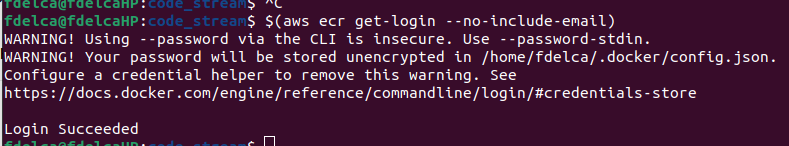

Push it to remote image - for that we need to give the local and the URI (of the REMOTE image)

```bash
REMOTE_URI="170107914870.dkr.ecr.eu-west-1.amazonaws.com/duration-model"
REMOTE_TAG="v1"
REMOTE_IMAGE=${REMOTE_URI}:${REMOTE_TAG}

LOCAL_IMAGE="stream-model-duration:v1"
docker tag ${LOCAL_IMAGE} ${REMOTE_IMAGE}
docker push ${REMOTE_IMAGE}
```

- Echo $REMOTE_IMAGE: `170107914870.dkr.ecr.eu-west-1.amazonaws.com/duration-model:v1`

And this is what our lambda function will use as a docker image

#### 5.1 Create a new lambda function using `Container Image`

Configuration:
- Name: `ride-duration-prediction`
- Container Image URI: `170107914870.dkr.ecr.us-east-1.amazonaws.com/duration-model:v1`
- Use existing role: `lambda-kinesis-role`
- Create function

**Extra Configure**

- Configure > Add environmental variables;
- PREDICTIONS_STREAM_NAM
- RUN_ID

- Add Triggers > Kinesis `ride-events`
- Delete the `ride-duration-prediction-test` function because it depends on the same `Kinesis`

- **We need to add permissions - policy so the lambda function can talk with the s3 bucket**

#### 5.2 Send test

##### 5.2.1 - In the AWS by sending a record:

##### 5.2.2. - Using bash

```bash
KINESIS_STREAM_INPUT=ride-events
aws kinesis put-record \
    --stream-name ${KINESIS_STREAM_INPUT} \
    --partition-key 1 \
    --data '{
        "ride": {
            "PULocationID": 130,
            "DOLocationID": 205,
            "trip_distance": 3.66
        }, 
        "ride_id": 156
    }'
```

Any question check the video: [link](https://www.youtube.com/watch?v=18Lbaaeigek&list=PL3MmuxUbc_hIUISrluw_A7wDSmfOhErJK&index=32)

### Just to know the names before terminate - should be created before using

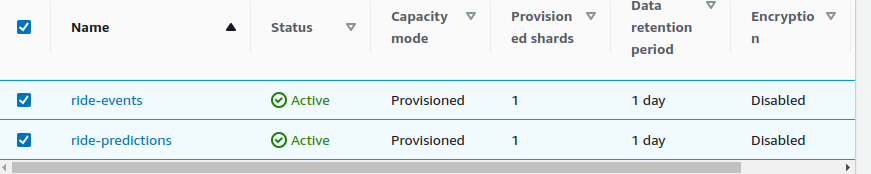